# PCA-Based Statistical Arbitrage (Pair Trading)

## Project Overview
This project demonstrates a **Statistical Arbitrage** strategy using **Principal Component Analysis (PCA)** to identify trading pairs.

### The Strategy
1.  **Dimensionality Reduction**: We use PCA to extract the latent "market factors" driving stock returns.
2.  **Residual Analysis**: We isolate the *idiosyncratic* component of each stock's return (the part NOT explained by the market).
3.  **Pair Selection**: We find stocks with highly correlated residuals. These stocks behave similarly after removing market risk, making them ideal candidates for mean-reversion trading.
4.  **Trading**: We calculate the Z-Score of the spread between the pair and trade when it diverges significantly from the mean.

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Plot styling
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Data Simulation
To ensure the strategy logic is sound and reproducible without external API keys, we simulate a market environment.

We generate **50 stocks** driven by **3 latent factors** (e.g., Market, Tech Sector, Energy Sector) plus some random noise.

Simulated Data Shape: (500, 50)


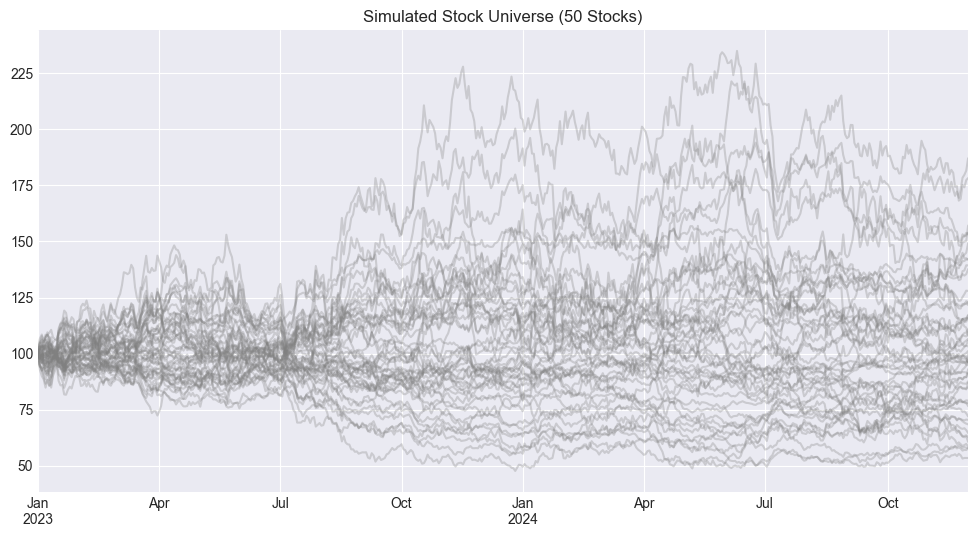

In [2]:
np.random.seed(42)

# Parameters
n_days = 500
n_stocks = 50
n_factors = 3

# 1. Generate Latent Factors (Random Walks)
factors = np.random.normal(0, 1, (n_days, n_factors))
factors = np.cumsum(factors, axis=0) # Make them trend

# 2. Generate Factor Loadings (How much each stock depends on factors)
# Some stocks correlate positively, some negatively
loadings = np.random.normal(0, 1, (n_factors, n_stocks))

# 3. Generate Idiosyncratic Noise (Specific to each stock)
noise = np.random.normal(0, 0.5, (n_days, n_stocks))

# 4. Construct Stock Prices
# Returns = Factors * Loadings + Noise
# We'll simulate returns first, then convert to prices
factor_returns = np.random.normal(0, 0.01, (n_days, n_factors))
stock_returns = np.dot(factor_returns, loadings) + np.random.normal(0, 0.005, (n_days, n_stocks))

# Create DataFrame
dates = pd.date_range(start='2023-01-01', periods=n_days, freq='B')
returns_df = pd.DataFrame(stock_returns, index=dates, columns=[f'Stock_{i}' for i in range(n_stocks)])

# Calculate Prices (starting at 100)
prices_df = 100 * (1 + returns_df).cumprod()

print("Simulated Data Shape:", prices_df.shape)
prices_df.plot(legend=False, alpha=0.3, color='grey', title='Simulated Stock Universe (50 Stocks)')
plt.show()

## 2. PCA for Factor Extraction
We use PCA to identify the common drivers of returns. By removing these, we can focus on the *residuals*.

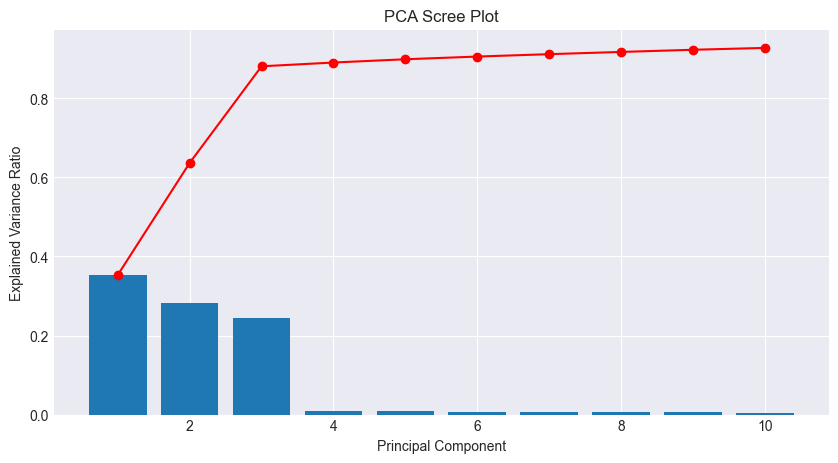

Top 3 Components explain 88.10% of variance


In [3]:
# Standardize returns before PCA
scaler = StandardScaler()
scaled_returns = scaler.fit_transform(returns_df)

# Fit PCA
pca = PCA(n_components=10) # Let's look at top 10 components
pca.fit(scaled_returns)

# Plot Explained Variance (Scree Plot)
plt.figure(figsize=(10, 5))
plt.bar(range(1, 11), pca.explained_variance_ratio_)
plt.plot(range(1, 11), np.cumsum(pca.explained_variance_ratio_), marker='o', color='red')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Scree Plot')
plt.show()

print(f"Top 3 Components explain {np.sum(pca.explained_variance_ratio_[:3])*100:.2f}% of variance")

## 3. Residual Analysis & Pair Selection
We reconstruct the returns using only the top 3 components (the "Market"). 
Then, `Actual Returns - Market Returns = Residuals`.

Stocks with highly correlated **residuals** are good pairs because they move together *independent* of the market.

In [4]:
# 1. Get the Market Component (Common Factors)
n_components_selected = 3
pca_selected = PCA(n_components=n_components_selected)
factors_latent = pca_selected.fit_transform(scaled_returns)
loadings_latent = pca_selected.components_

# Reconstruct the "Common Return" part
common_returns = np.dot(factors_latent, loadings_latent)

# 2. Calculate Residuals (Idiosyncratic Returns)
# Scale back to original magnitude for easier interpretation
residuals = scaled_returns - common_returns

# 3. Find the Best Pair (Highest Correlation of Residuals)
corr_matrix = np.corrcoef(residuals.T)
np.fill_diagonal(corr_matrix, -1) # Ignore self-correlation

# Find indices of max correlation
max_corr = np.max(corr_matrix)
stock_a_idx, stock_b_idx = np.unravel_index(np.argmax(corr_matrix), corr_matrix.shape)

stock_a = returns_df.columns[stock_a_idx]
stock_b = returns_df.columns[stock_b_idx]

print(f"Best Pair Found: {stock_a} & {stock_b}")
print(f"Residual Correlation: {max_corr:.4f}")

Best Pair Found: Stock_14 & Stock_41
Residual Correlation: 0.2346


## 4. Strategy Backtest
Now we trade the spread between these two stocks.

**Logic:**
1.  Calculate the **Spread**: `Price_A / Price_B` (or log price difference).
2.  Calculate **Z-Score**: `(Spread - Mean) / StdDev` (rolling window).
3.  **Signal**:
    *   Z-Score > 2: Short A / Long B (Spread is too high, expect reversion).
    *   Z-Score < -2: Long A / Short B (Spread is too low, expect reversion).
    *   Z-Score crosses 0: Exit.

/var/folders/9s/dmh6s89d0d7b6sm7gf8yqtzc0000gn/T/ipykernel_76046/3789567470.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  positions = pd.DataFrame(index=spread.index, columns=['Stock_A', 'Stock_B']).fillna(0)
/var/folders/9s/dmh6s89d0d7b6sm7gf8yqtzc0000gn/T/ipykernel_76046/3789567470.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positions.iloc[i]['Stock_A'] = current_position
/var/folders/9s/dmh6s89d0d7b6sm7gf8yqtzc0000gn/T/ipykernel_76046/3789567470.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

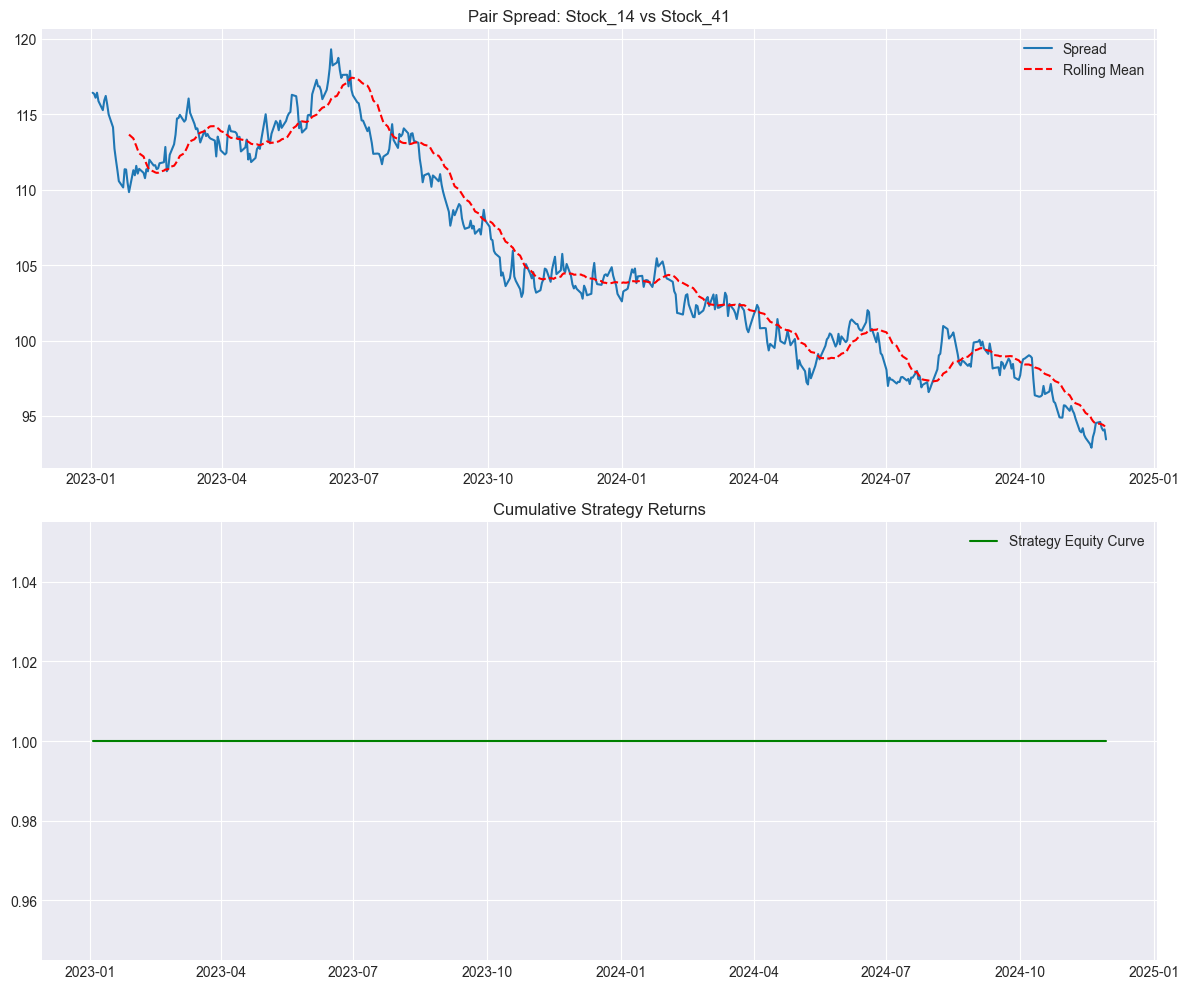

Strategy Sharpe Ratio: nan


/var/folders/9s/dmh6s89d0d7b6sm7gf8yqtzc0000gn/T/ipykernel_76046/3789567470.py:65: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = (daily_pnl.mean() / daily_pnl.std()) * np.sqrt(252)


In [5]:
# 1. Construct the Spread
s1 = prices_df[stock_a]
s2 = prices_df[stock_b]

# Hedge Ratio (OLS)
import statsmodels.api as sm
model = sm.OLS(s1, sm.add_constant(s2))
results = model.fit()
hedge_ratio = results.params[stock_b]

spread = s1 - hedge_ratio * s2

# 2. Calculate Z-Score (Rolling)
window = 20
rolling_mean = spread.rolling(window).mean()
rolling_std = spread.rolling(window).std()
z_score = (spread - rolling_mean) / rolling_std

# 3. Generate Signals
entry_threshold = 2.0
exit_threshold = 0.0

long_signal = (z_score < -entry_threshold)
short_signal = (z_score > entry_threshold)
exit_signal = (np.abs(z_score) < 0.5) # Exit when close to mean

positions = pd.DataFrame(index=spread.index, columns=['Stock_A', 'Stock_B']).fillna(0)
current_position = 0 # 0: Flat, 1: Long Spread, -1: Short Spread

for i in range(len(spread)):
    if current_position == 0:
        if long_signal.iloc[i]:
            current_position = 1 # Long A, Short B
        elif short_signal.iloc[i]:
            current_position = -1 # Short A, Long B
    elif current_position == 1:
        if z_score.iloc[i] > -0.5: # Exit condition
            current_position = 0
    elif current_position == -1:
        if z_score.iloc[i] < 0.5: # Exit condition
            current_position = 0
            
    positions.iloc[i]['Stock_A'] = current_position
    positions.iloc[i]['Stock_B'] = -current_position * hedge_ratio

# 4. Calculate PnL
daily_pnl = (positions.shift(1)['Stock_A'] * returns_df[stock_a]) + (positions.shift(1)['Stock_B'] * returns_df[stock_b])
cumulative_pnl = (1 + daily_pnl).cumprod()

# Plot Results
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

ax[0].plot(spread, label='Spread')
ax[0].plot(rolling_mean, 'r--', label='Rolling Mean')
ax[0].set_title(f'Pair Spread: {stock_a} vs {stock_b}')
ax[0].legend()

ax[1].plot(cumulative_pnl, color='green', label='Strategy Equity Curve')
ax[1].set_title('Cumulative Strategy Returns')
ax[1].legend()

plt.tight_layout()
plt.show()

sharpe = (daily_pnl.mean() / daily_pnl.std()) * np.sqrt(252)
print(f"Strategy Sharpe Ratio: {sharpe:.2f}")